<a href="https://colab.research.google.com/github/judelo/NotebooksProject/blob/master/ImageGeneration/ImageReconstrutionLineSegments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image synthesis under Line Segments constraints

The problem of image synthesis under line segment constraints can be stated the following way:
we start from the result of the Line Segment Detector algorithm on an original image <a name="cite_ref-1"></a>[[1]](#cite_note-1), and we aim at generating a new image that has "most of the time" the same Line Segment detections as in the original image, following the approach of <a name="cite_ref-2"></a>[[2]](#cite_note-2).

This practical session shows how to obtain such new images.

**Authors:**
- Lucía Bouza
- [Agnès Desolneux](https://desolneux.perso.math.cnrs.fr)

## Importing packages

Below is a list of packages needed to implement the algorithms.

* `Numpy`
* `PIL.Image, matplotlib.pyplot` (display images and graphics)
* `os` (interactions with the operating system)
* `binom` (compute the probability distribution of the binomial law)

In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import binom

To import the solutions, execute the following cell. If you are using a Windows system, comment the `os.system` line, download the file by hand, and place it in the same folder as the notebook.

In [27]:
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/Solutions/ImgRecLineSegments.py")
from ImgRecLineSegments import *

## Loading images and files

In this section we upload two test images and their results of the LSD algorithm. These results were obtained using the IPOL demo [LSD: a Line Segment Detector](https://ipolcore.ipol.im/demo/clientApp/demo.html?id=38).

In [28]:
# Download the images and their results from the LSD algorithm
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Images/main/img/simpson_nb512.png")
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Images/main/img/chairs.png")
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/AuxiliarFunctions/output-chairs.txt")
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/ImageGeneration/AuxiliarFunctions/output-simpson.txt")

0

Next we display both images.

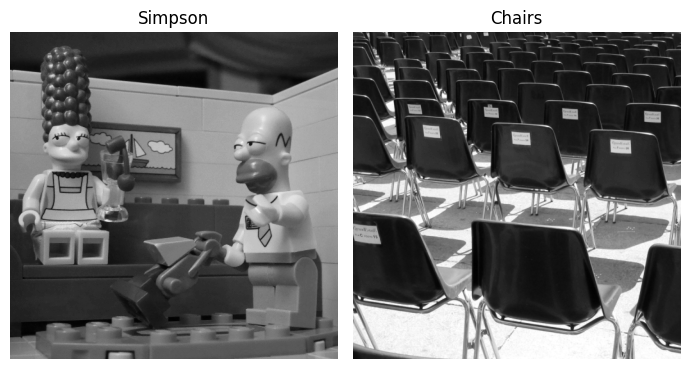

In [29]:
def printImages(a, b, title_a, title_b, size1, size2, cmap1, cmap2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap=cmap1)
    axes[0].axis('off')
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap=cmap2)
    axes[1].axis('off')
    fig.tight_layout()
    plt.show()

printImages(plt.imread("simpson_nb512.png"), plt.imread("chairs.png"), 'Simpson', 'Chairs', 7, 7, 'gray', 'gray')

In this cell we choose one of the images to work with.

In [30]:
# Load image
uo = plt.imread("simpson_nb512.png")
N, M = uo.shape

# Load LSD output
LSDres = np.loadtxt('output-simpson.txt')
nrect, nc = LSDres.shape

## 1. Line Segment Detector

The goal of the Line Segment Detector (LSD) algorithm <a name="cite_ref-1"></a>[[1]](#cite_note-1) is to identify locally straight contours within images. These straight edges are rectangular regions in the image where "a lot of" image gradients are perpendicular to the main axis of the rectangle. The threshold to define what "a lot of" means is computed by a statistical test. By taking a grayscale image as input, the LSD algorithm output is a list of detected rectangles.

### Algorithm

At the first step of the algorithm, the orientation of the gradient, rotated by $\pi/2$ is calculated at each pixel, resulting in an orientation field. This field consists in unit vectors that are tangential to the level line passing through their respective base points. Then, the field is segmented using a region growing process into connected regions of pixels that exhibit similar orientations, within a specific precision value. Each region is approximated by a rectangle, and a statistical test (based on the a contrario approach) is performed to associate a NFA (Number of False Alarm) to it. Line segments are rectangles that contain enough aligned orientations, such that their NFA is $<1$.

The output of the LSD algorithm is a text file, with as many lines as detected rectangles, each consisting of seven numbers separated by spaces: *x1, y1, x2, y2, width, p, and -log_nfa*. Here (x1, y1) is the coordinate of the starting point of the line segment (medial axis of the rectangle), (x2, y2) is the coordinate of the end point of the line, width is the width of the rectangle and $p$ is the alignment precision value. The last value is -log_nfa, where NFA is the number of false alarms of the rectangle.

**Question 1** Write a function to visualize the output rectangles, as a grayscale image. This image should represent the sum of the indicator functions of the detected rectangles.


**Question 2** Check that the detected rectangles almost never overlap. Check also that the precision for the detections is almost always 1/8.

In [31]:
def visualize_rectangles(im):
    gray_image = im

    # make plot
    fig, ax = plt.subplots()

    # show image
    shw = ax.imshow(gray_image, interpolation='None', cmap='gray')

    # make bar
    bar = plt.colorbar(shw)

    plt.axis('off')
    plt.show()


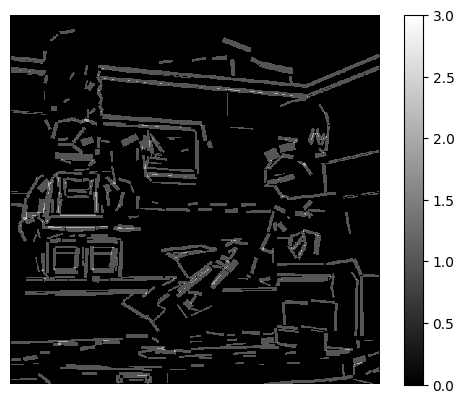

In [32]:
ImRect = reconstructRectangles(LSDres, N, M)
visualize_rectangles(ImRect)

In [33]:
LSD_Statistics(LSDres, ImRect)

-------------------------------------------------
Number of detected rectangles:  433
Percentage of overlap within area covered by rectangles:  2.37
Percentage of overlap with respect to the total number of pixels:  0.41
Number of detected rectangles with precision 1/8:  416
Percentage of detected rectangles with precision 1/8:  96.07390300230946
-------------------------------------------------


## 2. Image synthesis under Line Segments constraints

Given a grayscale image $u^0$ defined on a discrete domain
$\Omega=\{0,\ldots,M-1\}\times\{0,\ldots,N-1\}$, we compute its orientation field $\theta^0:\Omega\to S^1=[0,2\pi)$ as the orientation field of the level lines of $u^0$, that is

$$
\forall x\in\Omega , \hspace{0.3cm} \theta^0(x) = \frac{\pi}{2} + \text{Arg}
\frac{\nabla u^0(x)}{\| \nabla u^0(x) \|} ,
$$
where $\nabla u^0$ is the gradient of $u^0$.

We are interested in generating a new image that has "most of the time" the same Line Segment detections as in $\theta^0$, while being at the same time "as random as possible". We will start by sampling a new orientation field, and then we will see how to go from an orientation field to an image.

In the next cell we compute the gradient and the orientation field of the image ($\theta^0$) .

In [34]:
# Compute Gradient of image
Gradx = 0.5 * (uo[1:N, 0:M-1] + uo[1:N, 1:M] - uo[0:N-1, 0:M-1] - uo[0:N-1, 1:M])
Grady = 0.5 * (uo[0:N-1, 1:M] + uo[1:N, 1:M] - uo[0:N-1, 0:M-1] - uo[1:N, 0:M-1])

# Compute Theta
Theta0 = np.zeros((N, M))
Theta0[0:N-1, 0:M-1] = np.angle(1j * Gradx - Grady)

Let $\mathcal{Q}$ denote the set of probability distributions $Q$ on orientation fields $\Theta$ such that if the orientation field is sampled from $Q$ then, in most cases, the meaningul rectangles will be at least as meaningful as in $\theta^0$. In all the following, the precision is now fixed to $p=1/8$.

We would like to find a distribution in $\mathcal{Q} $ that would be "as random as possible", in the sense that is has maximum entropy among all distributions in $\mathcal{Q}$. The probability distribution in $\mathcal{Q}$ that has maximum entropy is denoted by $Q_0$. Under $Q_0$, we have that:

- the $\Theta_x$, for $x\in\Omega\setminus\cup_j r_j$, are uniform on $S^1=[0,2\pi)$ and independent from all other $\Theta_y$, $y\neq x$;

- the $\{\Theta_x\}_{x\in r_j}$ inside a rectangle $r_j$, $1\leq j\leq m$, are characterized by the marginal distribution of $k(r_j;\Theta)$, the number of aligned points (i.e. pixels such that their orientation is aligned with the one of the rectangle up to precision $p$) in $r_j$, that follows the law:

$$
\mathbb{P}_{Q_0}[k(r_j;\Theta) = k] = \left\{
    \begin{array}{cc}
\frac{1}{2(1-q_{r_j})} \binom{n(r_j)}{k} p^k (1-p)^{n-k} & \text{ if } k < k(r_j;\theta^0) \\
  \frac{1}{2 q_{r_j}} \binom{n(r_j)}{k} p^k (1-p)^{n-k} & \text{ if } k \geq k(r_j;\theta^0)    
    \end{array} \right.     ,
$$

where $q_{r_j}:= B(k(r_j;\theta^0);n(r_j),p)$ with $B$ denoting the binomial tail. Then, conditionally to $k(r_j;\Theta) = k$, to sample from $Q_0$, first choose $k$ pixels among the $n(r_j)$ pixels and draw their $\Theta_x$ independently according to the uniform distribution on $[\varphi(r_j)-p\pi , \varphi(r_j) + p\pi]$, where $\varphi(r_j)$ is the orientation of the rectangle. Finally draw  the other $\Theta_y$, $y\in r_j$ independently according to the uniform distribution on $S^1\setminus [\varphi(r_j)-p\pi , \varphi(r_j) + p\pi]$.

**Question 3:** Sample a new orientation field from the distribution $Q_0$.

In [35]:
ImNew = sampling_orientation_field(N,M,LSDres, Theta0)

Visualize the sample of the orientation field.

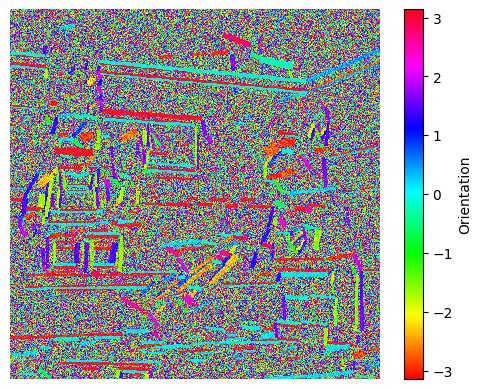

In [36]:
# make plot
fig, ax = plt.subplots()

# show image
shw = ax.imshow(ImNew, interpolation='None', cmap='hsv')

# make bar
bar = plt.colorbar(shw)

# show plot with labels
plt.xlabel('X Label')
plt.ylabel('Y Label')
bar.set_label('Orientation')
plt.axis('off')
plt.show()

## 3. From an orientation field to an image

Once we have a sample $\theta$ of an orientation field, how can we obtain an image? This can be done using the Poisson editing method. Now, for the Poisson
editing, we need a vector field as an input. Here, we have the orientations of the vectors but not their amplitudes. We can fix them arbitrarily, for instance taking
an amplitude $R=1$ everywhere, or taking
a different amplitude on the pixels that are in rectangles or not. We will set

$$V(x) = Re^{i\theta_x} \text{ if } x\in \cup_j r_j , \quad  V(x) =
e^{i\theta_x} \text{ otherwise} . $$

### Poisson reconstruction

Given a vector field $V=(v_1,v_2)$ defined on a discrete domain $\Omega=\{0,\ldots,M-1\}\times \{0,\ldots,N-1\}$, the aim of Poisson reconstruction is to find an image $u$ defined on $\Omega$ and such that the gradient of $u$ is close to $V$ for the $L^2$ norm.

This problem is solved in the Fourier domain by taking
$ \forall \xi\in\Omega\setminus\{0\} , \hspace{0.3cm} \widehat{u}(\xi) =
\frac{\frac{2i\pi\xi_1}{M}\widehat{v_1}(\xi) +
  \frac{2i\pi\xi_2}{N}\widehat{v_2}(\xi)}{\left(\frac{2i\pi\xi_1}{M}\right)^2
+ \left(\frac{2i\pi\xi_2}{N}\right)^2}  $
and $\widehat{u}(0)$ equal to any arbitrary constant (this is the mean
value of the reconstructed image $u$).


**Question 4** Reconstruct an image from the previous sample using the Poisson reconstruction method, trying different amplitudes: $R=1$ or $R=100$ for the rectangles.

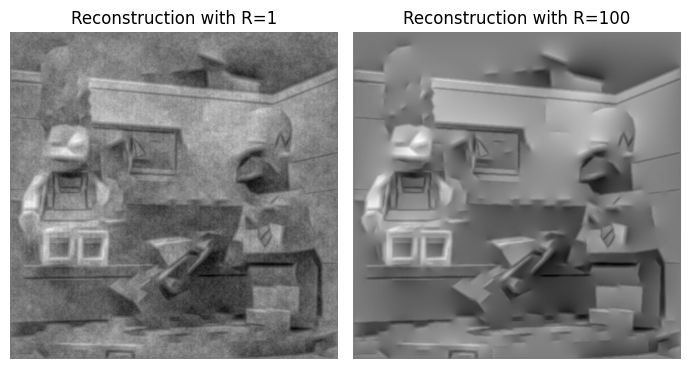

In [37]:
# Set amplitude to -1 for random amplitude.
Reconst_1 = reconstruction(vectorField = ImNew, amplitude = 1, ImRect = ImRect )
Reconst_100 = reconstruction(vectorField = ImNew, amplitude = 100, ImRect = ImRect)

printImages(Reconst_1, Reconst_100, 'Reconstruction with R=1', 'Reconstruction with R=100', 7, 7, 'gray', 'gray')

## References


<a name="cite_note-1"></a>[1] [](#cite_ref-1) Rafael Grompone von Gioi, Jérémie Jakubowicz, Jean-Michel Morel, and Gregory Randall, LSD: a Line Segment Detector, Image Processing On Line, 2 (2012), pp. 35–55. http://www.ipol.im/pub/art/2012/gjmr-lsd/

<a name="cite_note-2"></a>[2] [](#cite_ref-2) Agnès Desolneux. When the a contrario approach becomes generative. Int. J. Comput. Vision 116, 1 (2016), 46–65. https://doi.org/10.1007/s11263-015-0825-x